# Workflow for a multi-regional energy system

In this application of the FINE framework, a multi-regional energy system is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [1]:
import FINE as fn
from getData import getData
import os
cwd = os.getcwd()
data = getData()

%matplotlib inline  
%reload_ext autoreload
%autoreload 2

In [2]:
# import matplotlib.pyplot as plt
# fig, axes = plt.subplots()
# data['Wind (offshore), operationRateMax'].plot(ax=axes) # CF
# data['Wind (onshore), operationRateMax'].plot(ax=axes) # CF
# data['PV, operationRateMax'].plot(ax=axes) # CF
# data['Existing run-of-river plants, operationRateFix'].plot(ax=axes) # CF
# data['Electricity demand, operationRateFix'].plot(ax=axes) # GW
# data['Hydrogen demand, operationRateFix'].plot(ax=axes) # GW

# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [3]:
locations = {'es', 'pt', 'fr', 'be', 'lu', 'nl', 'de', 'dk', 'cz', 'pl', 'sk', 'ch', 'at', 'it', 'si', 'hu', 'ro', 'hr', 'ba', 'me', 'rs', 'bg', 'mk', 'gr', 'al', 'ee', 'fi', 'lt', 'lv', 'no', 'se', 'uk', 'ie'}
locations = {nation.upper() for nation in locations}

commodityUnitDict = {'electricity': r'GW$_{el}$', 'methane': r'GW$_{CH_{4},LHV}$',
                     'CO2': r'Mio. t$_{CO_2}$/h', 'hydrogen': r'GW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen', 'methane', 'CO2'}
numberOfTimeSteps = 8760
hoursPerTimeStep = 1

In [4]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760, 
                           commodityUnitsDict=commodityUnitDict, hoursPerTimeStep=1, 
                           costUnit='1e9 Euro', lengthUnit='km', verboseLogLevel=0)

In [5]:
CO2_reductionTarget = 1

# 3. Add commodity sources to the energy system model

## 3.1. Electricity sources

### Wind onshore

In [6]:
esM.add(fn.Source(esM=esM, name='Wind (onshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (onshore), operationRateMax'], capacityMax = data['Wind (onshore), capacityMax'],
                  investPerCapacity=1.1, opexPerCapacity=1.1*0.02, interestRate=0.08,
                  economicLifetime=25))

In [7]:
from os.path import join
cwd = os.getcwd()
data_path = 'C:\\Users\\r.beer\\code\\git_repos\\FINE\\examples\\EU_without_aggregation' + '\\InputData\\SpatialData\\'

# visualize shapefiles
path_e_highway_sev2 = join(data_path, 'ShapeFiles\\e-highway_sev2.shp')
path_e_highway_sev_full = join(data_path, 'ShapeFiles\\e-highway_sev-full.shp')


### Wind offshore

In [8]:
esM.add(fn.Source(esM=esM, name='Wind (offshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (offshore), operationRateMax'],
                  capacityMax=data['Wind (offshore), capacityMax'],
                  investPerCapacity=2.3, opexPerCapacity=2.3*0.02, interestRate=0.08,
                  economicLifetime=20))

### PV

In [9]:
esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['PV, operationRateMax'], capacityMax=data['PV, capacityMax'],
                  investPerCapacity=0.65, opexPerCapacity=0.65*0.02, interestRate=0.08,
                  economicLifetime=25))

### Exisisting run-of-river hydroelectricity plants

In [10]:
esM.add(fn.Source(esM=esM, name='Existing run-of-river plants', commodity='electricity',
                  hasCapacityVariable=True,
                  operationRateFix=data['Existing run-of-river plants, operationRateFix'], tsaWeight=0.01,
                  capacityFix=data['Existing run-of-river plants, capacityFix'],
                  investPerCapacity=0, opexPerCapacity=0.208))

## 3.2. Methane (natural gas and biogas)

### Natural gas

In [11]:
esM.add(fn.Source(esM=esM, name='Natural gas purchase', commodity='methane',
                  hasCapacityVariable=False, commodityCost=0.0331*1e-3))

### Biogas

In [12]:
# esM.add(fn.Source(esM=esM, name='Biogas purchase', commodity='biogas',
#                   operationRateMax=data['Biogas, operationRateMax'], hasCapacityVariable=False,
#                   commodityCost=0.05409*1e-3))


### CO2

The CO2 source is required for the case in which it can be mixed with conventional natural gas.

In [13]:
esM.add(fn.Source(esM=esM, name='CO2 from enviroment', commodity='CO2',
                  hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

# 4. Add conversion components to the energy system model

### Combined cycle gas turbine plants

In [14]:
esM.add(fn.Conversion(esM=esM, name='CCGT plants (methane)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity': 1, 'methane': -1/0.625, 'CO2': 201*1e-6/0.625},
                      hasCapacityVariable=False,
                      investPerCapacity=0.65, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycle gas turbine plants for biogas

In [15]:
# esM.add(fn.Conversion(esM=esM, name='New CCGT plants (biogas)', physicalUnit=r'GW$_{el}$',
#                       commodityConversionFactors={'electricity':1, 'biogas':-1/0.635},
#                       hasCapacityVariable=True, 
#                       investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
#                       economicLifetime=33))

### New combined cycly gas turbines for hydrogen

In [16]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (hydrogen)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### Electrolyzers

In [17]:
esM.add(fn.Conversion(esM=esM, name='Electroylzers', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.5, opexPerCapacity=0.5*0.025, interestRate=0.08,
                      economicLifetime=10))

### rSOC

In [18]:
# capexRSOC=1.5

# esM.add(fn.Conversion(esM=esM, name='rSOEC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
#                       commodityConversionFactors={'electricity':-1, 'hydrogen':0.6},
#                       hasCapacityVariable=True, 
#                       investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
#                       economicLifetime=10))

# esM.add(fn.Conversion(esM=esM, name='rSOFC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
#                       commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
#                       hasCapacityVariable=True, 
#                       investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
#                       economicLifetime=10))

# 5. Add commodity storages to the energy system model

## 5.1. Electricity storage

### Lithium ion batteries

The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [19]:
esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.95,
                   cyclicLifetime=10000, dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)),
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                   economicLifetime=22))

## 5.2. Hydrogen storage

### Hydrogen filled salt caverns
The maximum capacity is here obtained by: dividing the given capacity (which is given for methane) by the lower heating value of methane and then multiplying it with the lower heating value of hydrogen.

In [20]:
# esM.add(fn.Storage(esM=esM, name='Salt caverns (hydrogen)', commodity='hydrogen',
#                    hasCapacityVariable=True, capacityVariableDomain='continuous',
#                    capacityPerPlantUnit=133,
#                    chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
#                    stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (hydrogen), capacityMax'],
#                    investPerCapacity=0.00011, opexPerCapacity=0.00057, interestRate=0.08,
#                    economicLifetime=30))

## 5.3. Methane storage

### Methane filled salt caverns

In [21]:
# esM.add(fn.Storage(esM=esM, name='Salt caverns (biogas)', commodity='biogas',
#                    hasCapacityVariable=True, capacityVariableDomain='continuous',
#                    capacityPerPlantUnit=443,
#                    chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
#                    stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (methane), capacityMax'],
#                    investPerCapacity=0.00004, opexPerCapacity=0.00001, interestRate=0.08,
#                    economicLifetime=30))

## 5.4 Pumped hydro storage

### Pumped hydro storage

In [22]:
# esM.add(fn.Storage(esM=esM, name='Pumped hydro storage', commodity='electricity',
#                    chargeEfficiency=0.88, dischargeEfficiency=0.88,
#                    hasCapacityVariable=True, selfDischarge=1-(1-0.00375)**(1/(30*24)),
#                    chargeRate=0.16, dischargeRate=0.12, capacityFix=data['Pumped hydro storage, capacityFix'],
#                    investPerCapacity=0, opexPerCapacity=0.000153))

# 6. Add commodity transmission components to the energy system model

## 6.1. Electricity transmission

### AC cables

In [23]:
esM.add(fn.Transmission(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix']))

The distances of a component are set to a normalized value of 1.


In [24]:
# esM.add(fn.Transmission(esM=esM, name='AC cables', commodity='electricity',
#                                   hasCapacityVariable=False))

### DC cables

In [25]:
# esM.add(fn.Transmission(esM=esM, name='DC cables', commodity='electricity', losses=data['DC cables, losses'],
#                         distances=data['DC cables, distances'],
#                         hasCapacityVariable=True, capacityFix=data['DC cables, capacityFix']))

## 6.2 Methane transmission

### Methane pipeline

In [26]:
# esM.add(fn.Transmission(esM=esM, name='Pipelines (biogas)', commodity='biogas', 
#                         distances=data['Pipelines, distances'],
#                         hasCapacityVariable=True, hasIsBuiltBinaryVariable=False, bigM=300,
#                         locationalEligibility=data['Pipelines, eligibility'],
#                         capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
#                         investPerCapacity=0.000037, investIfBuilt=0.000314,
#                         interestRate=0.08, economicLifetime=40))

esM.getComponent('Pipelines (methane)')._mapC['cluster_0_cluster_4'][1]

## 6.3 Hydrogen transmission

### Hydrogen pipelines

In [27]:
# esM.add(fn.Transmission(esM=esM, name='Pipelines (hydrogen)', commodity='hydrogen',
#                         distances=data['Pipelines, distances'],
#                         hasCapacityVariable=True, hasIsBuiltBinaryVariable=False, bigM=300,
#                         locationalEligibility=data['Pipelines, eligibility'],
#                         capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
#                         investPerCapacity=0.000177, investIfBuilt=0.00033,
#                         interestRate=0.08, economicLifetime=40))

esM.getComponent('Pipeline (hydrogen)')._mapC

# 7. Add commodity sinks to the energy system model

## 7.1. Electricity sinks

### Electricity demand

In [28]:
esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']))

## 7.2. Hydrogen sinks

### Fuel cell electric vehicle (FCEV) demand

In [29]:
# FCEV_penetration=0.5
# esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
#                 operationRateFix=data['Hydrogen demand, operationRateFix']*FCEV_penetration))

## 7.3. CO2 sinks

### CO2 exiting the system's boundary

In [30]:
esM.add(fn.Sink(esM=esM, name='CO2 to enviroment', commodity='CO2',
                hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

# 8. Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [31]:
esM.cluster(numberOfTypicalPeriods=6)


Clustering time series data with 6 typical periods and 24 time steps per period...


C:\Users\r.beer\AppData\Local\Continuum\anaconda3\envs\spagat_py37\lib\site-packages\tsam\timeseriesaggregation.py:728: UserWarning: Max iteration number reached while rescaling the cluster periods
  'Max iteration number reached while rescaling the cluster periods')


		(15.9408 sec)



In [32]:
esM.optimize(timeSeriesAggregation=True, optimizationSpecs='OptimalityTol=1e-3 cuts=0 method=2')

Time series aggregation specifications:
Number of typical periods:6, number of time steps per periods:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.0965 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2306 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(2.1186 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.5736 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring commodity balances...
		(1.5030 sec)

Declaring objective function...
		(0.6047 sec)

Academic license - for non-commercial use only
Read LP format model from file C:\Users\R2D98~1.BEE\AppData\Local\Temp\tmpt4lpkz5f.pyomo.lp
Rea

  80*  6.67306017e+12  6.61157925e+14  6.40e-04 4.87e-02  5.41e-03    15s
  81*  1.19958043e+13  6.98446443e+14  5.23e-04 2.83e-02  3.35e-03    15s
  82*  1.30981038e+13  7.08820247e+14  5.06e-04 1.74e-02  3.24e-03    16s
  83*  1.37218578e+13  7.15339884e+14  4.70e-04 1.86e-02  3.22e-03    16s
  84*  1.51798914e+13  7.25394824e+14  4.09e-04 1.42e-02  2.97e-03    16s
  85*  2.42248401e+13  8.10245172e+14  4.88e-04 7.67e-02  2.34e-03    16s
  86*  4.28322640e+13  9.45670572e+14  2.89e-04 9.90e-02  1.49e-03    16s
  87*  4.28321673e+13  9.45679391e+14  2.90e-04 7.26e-02  1.49e-03    17s
  88*  4.62790055e+13  1.05981063e+15  2.90e-04 7.23e-02  1.49e-03    17s
  89*  4.62732818e+13  1.05973025e+15  2.91e-04 7.23e-02  1.49e-03    17s
  90*  5.75797818e+13  1.08190376e+15  2.91e-04 7.22e-02  1.49e-03    17s
  91*  5.75797589e+13  1.08190345e+15  2.90e-04 7.22e-02  1.49e-03    17s
  92*  1.27272150e+14  1.14124194e+15  2.89e-04 7.19e-02  1.49e-03    18s
  93*  1.27273660e+14  1.14125504e+15 

  241735    6.0641578e+05   1.966416e+09   0.000000e+00    551s
  242668    6.0784791e+05   5.782580e+08   0.000000e+00    555s
  243610    6.0910743e+05   4.063447e+08   0.000000e+00    561s
  244114    6.0995159e+05   3.887843e+08   0.000000e+00    566s
  244618    6.1060970e+05   1.101740e+09   0.000000e+00    570s
  245118    6.1190992e+05   3.190930e+08   0.000000e+00    575s
  245521    6.1362448e+05   5.475562e+08   0.000000e+00    581s
  245923    6.1463094e+05   1.325147e+09   0.000000e+00    586s
  246327    6.1573757e+05   9.622024e+08   0.000000e+00    591s
  246836    6.1717775e+05   4.115234e+08   0.000000e+00    596s
  247348    6.1854081e+05   7.924781e+08   0.000000e+00    600s
  247850    6.1953287e+05   6.160653e+08   0.000000e+00    606s
  248251    6.2034636e+05   7.640577e+08   0.000000e+00    610s
  248760    6.2253097e+05   2.088690e+09   0.000000e+00    616s
  249364    6.2439989e+05   5.442573e+08   0.000000e+00    621s
  249869    6.2594173e+05   4.665803e+08

# 9. Selected results output

Plot locations (GeoPandas required)

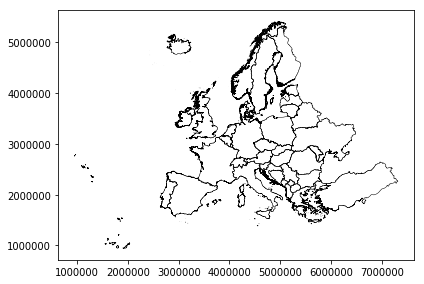

In [33]:
# locFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'european_countries/european_countries.shp')

locFilePath = os.path.join(r'C:\Users\r.beer\data\shapefiles\europe', 'Europe.shp')

fig1, ax = fn.plotLocations(locFilePath, plotLocNames=False, indexColumn='abbrev_1')


### Sources and Sink

Show optimization summary

In [35]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2).sum(axis=1)

AttributeError: 'NoneType' object has no attribute 'dropna'

Plot installed capacities

In [ ]:
# region_shapes_path = 'InputData/SpatialData/ShapeFiles/no data/clusteredRegions.shp'
region_shapes_path = os.path.join(r'C:\Users\r.beer\data\shapefiles\europe', 'Europe.shp')

import geopandas as gpd 
regional_shape_gdf = gpd.read_file(region_shapes_path)


In [ ]:
fig, ax = fn.plotLocationalColorMap(esM, 'PV', region_shapes_path, 'ISO2', perArea=True)

In [ ]:
fig, ax = fn.plotLocationalColorMap(esM, 'Wind (onshore)', region_shapes_path, 'ISO2', perArea=True)

In [ ]:
fig, ax = fn.plotLocationalColorMap(esM, 'Wind (offshore)', region_shapes_path, 'ISO2', perArea=True)

Plot operation time series (either one or two dimensional)

In [ ]:
fig, ax = fn.plotOperation(esM, 'Electricity demand', 'DE')

In [ ]:
fig, ax = fn.plotOperationColorMap(esM, 'Electricity demand', 'DE')

### Conversion

Show optimization summary

In [ ]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

In [ ]:
# fig, ax = fn.plotOperationColorMap(esM, 'New CCGT plants (biogas)', 'de')

### Storage

Show optimization summary

In [ ]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

In [ ]:
fig, ax = fn.plotOperationColorMap(esM, 'Li-ion batteries', 'DE', 
                                   variableName='stateOfChargeOperationVariablesOptimum')

In [ ]:
# fig, ax = fn.plotOperationColorMap(esM, 'Pumped hydro storage', 'de',
#                                   variableName='stateOfChargeOperationVariablesOptimum')

In [ ]:
# fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (biogas)', 'de',
#                                   variableName='stateOfChargeOperationVariablesOptimum')

In [ ]:
# fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (hydrogen)', 'de',
#                                   variableName='stateOfChargeOperationVariablesOptimum')

## Transmission

Show optimization summary

In [ ]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2)

Check that the shared capacity of the pipelines are not exceeded

In [ ]:
# df=esM.componentModelingDict["TransmissionModel"].capacityVariablesOptimum
# df.loc['Pipelines (biogas)']+df.loc['Pipelines (hydrogen)']

Plot installed transmission capacities

In [ ]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'AClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'AC cables', transFilePath, loc0='bus0', loc1='bus1', fig=fig, ax=ax)

In [ ]:
# transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'DClines.shp')

# fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
# fig, ax = fn.plotTransmission(esM, 'DC cables', transFilePath, loc0='cluster0', loc1='cluster1', fig=fig, ax=ax)

In [ ]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (hydrogen)', transFilePath, loc0='cluster0', loc1='cluster1',
                              fig=fig, ax=ax)

In [ ]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (biogas)', transFilePath, loc0='cluster0', loc1='cluster1',
                              fig=fig, ax=ax)